In [2]:
import torch, detectron2

TORCH_VERSION = ".".join(torch.__version__.split(".")[:2])
CUDA_VERSION = torch.__version__.split("+")[-1]
print("torch: ", TORCH_VERSION, "; cuda: ", CUDA_VERSION)
print("detectron2:", detectron2.__version__)
import detectron2
from detectron2.utils.visualizer import ColorMode

from detectron2.utils.logger import setup_logger
setup_logger()

torch:  1.12 ; cuda:  cu102
detectron2: 0.6


<Logger detectron2 (DEBUG)>

In [3]:
import numpy as np
import os, json, cv2, random
import cv2

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog

In [4]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

'im = cv2.imread("./input.jpg")\n\ncv2.imshow("hi", im)'

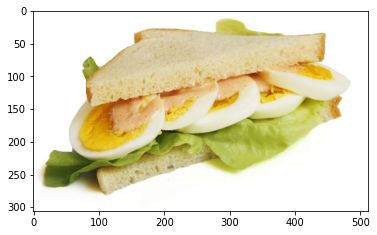

In [5]:
!wget https://upload.wikimedia.org/wikipedia/commons/f/ff/Egg_Sandwich.jpg -q -O input.jpg

img = mpimg.imread('./input.jpg')
imgplot = plt.imshow(img)

'''im = cv2.imread("./input.jpg")

cv2.imshow("hi", im)'''

In [6]:
cfg = get_cfg()
# add project-specific config (e.g., TensorMask) here if you're not running a model in detectron2's core library
cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/faster_rcnn_R_50_C4_1x.yaml"))
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5  # set threshold for this model

# Find a model from detectron2's model zoo. You can use the https://dl.fbaipublicfiles... url as well
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-Detection/faster_rcnn_R_50_C4_1x.yaml")
predictor = DefaultPredictor(cfg)
outputs = predictor(img)

/home/ubuntu/.local/lib/python3.8/site-packages/torch/functional.py:478: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2895.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


In [7]:
torch.cuda.get_device_name(0)

'Tesla T4'

In [8]:
# look at the outputs. See https://detectron2.readthedocs.io/tutorials/models.html#model-output-format for specification
print(outputs["instances"].pred_classes)
print(outputs["instances"].pred_boxes)

tensor([29, 79, 79, 55], device='cuda:0')
Boxes(tensor([[ 59.1650, 128.6693, 204.3395, 232.7061],
        [148.8553,  89.0132, 399.3745, 191.3522],
        [185.9847,  59.9381, 477.8551, 186.3280],
        [ 37.4249,  25.9518, 497.6705, 269.2760]], device='cuda:0'))


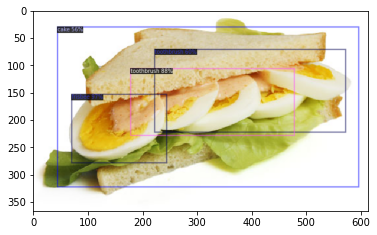

In [9]:
import matplotlib.pyplot as plt

v = Visualizer(img[:, :, :], MetadataCatalog.get(cfg.DATASETS.TRAIN[0]), scale=1.2)
out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
plt.imshow(out.get_image())

In [78]:
from detectron2.data.datasets import register_coco_instances
from detectron2.data.datasets.coco import convert_to_coco_dict
from detectron2.data.datasets.coco import load_coco_json

register_coco_instances("train11", {}, "train/train.json", "train/images")
register_coco_instances("val11", {}, "val/test.json", "val/images")

AssertionError: Dataset 'train11' is already registered!

In [79]:
detectron_dict = load_coco_json("train/train.json", "train/images", "YAY")
#coco_dict = convert_to_coco_dict("train11")

[08/03 00:59:24 d2.data.datasets.coco]: Loading train/train.json takes 2.08 seconds.
WARNING [08/03 00:59:24 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[08/03 00:59:24 d2.data.datasets.coco]: Loaded 24119 images in COCO format from train/train.json


In [80]:
len(coco_dict["categories"])

273

In [81]:
meta = MetadataCatalog.get("train11")

In [82]:
meta

namespace(name='train11',
          json_file='train/train.json',
          image_root='train/images',
          evaluator_type='coco',
          thing_classes=['beetroot-steamed-without-addition-of-salt',
                         'green-bean-steamed-without-addition-of-salt',
                         'watermelon-fresh',
                         'pizza-with-ham-baked',
                         'pizza-with-vegetables-baked',
                         'applesauce-unsweetened-canned',
                         'quiche-with-cheese-baked-with-puff-pastry',
                         'sweet-potato',
                         'country-fries',
                         'potato-gnocchi',
                         'potatoes-steamed',
                         'chips-french-fries',
                         'rosti',
                         'vegetable-mix-peas-and-carrots',
                         'mixed-vegetables',
                         'ratatouille',
                         'mixed-salad-chopped-wi

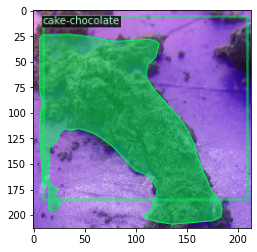

In [84]:
d = detectron_dict[0]
img = cv2.imread(d["file_name"])
visualizer = Visualizer(img[:,:,::-1], metadata= meta, scale = 0.5)
out = visualizer.draw_dataset_dict(d)
plt.imshow(out.get_image()[:,:,::-1])


In [129]:
from detectron2.engine import DefaultTrainer
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
cfg.DATASETS.TRAIN = ("train11",)
cfg.DATASETS.TEST = ()
cfg.DATALOADER.NUM_WORKERS = 0
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")  # Let training initialize from model zoo
cfg.SOLVER.IMS_PER_BATCH = 1  # This is the real "batch size" commonly known to deep learning people
cfg.SOLVER.BASE_LR = 0.00025  # pick a good LR
cfg.SOLVER.MAX_ITER =  150000 # 300 iterations seems good enough for this toy dataset; you will need to train longer for a practical dataset
cfg.SOLVER.STEPS = []        # do not decay learning rate
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 512   # The "RoIHead batch size". 128 is faster, and good enough for this toy dataset (default: 512)
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 273  # only has one class (ballon). (see https://detectron2.readthedocs.io/tutorials/datasets.html#update-the-config-for-new-datasets)
# NOTE: this config means the number of classes, but a few popular unofficial tutorials incorrect uses num_classes+1 here.

os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = DefaultTrainer(cfg) 
trainer.resume_or_load(resume=True)
trainer.train()

[08/03 04:20:19 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

In [106]:
%load_ext tensorboard
%tensorboard --logdir output

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


Reusing TensorBoard on port 6006 (pid 29456), started 6:42:28 ago. (Use '!kill 29456' to kill it.)

In [154]:
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")  # path to the model we just trained
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.05   # set a custom testing threshold
predictor = DefaultPredictor(cfg)

[08/03 14:15:38 d2.checkpoint.c2_model_loading]: Following weights matched with model:
| Names in Model                                  | Names in Checkpoint                                                                                  | Shapes                                          |
|:------------------------------------------------|:-----------------------------------------------------------------------------------------------------|:------------------------------------------------|
| backbone.bottom_up.res2.0.conv1.*               | backbone.bottom_up.res2.0.conv1.{norm.bias,norm.running_mean,norm.running_var,norm.weight,weight}    | (64,) (64,) (64,) (64,) (64,64,1,1)             |
| backbone.bottom_up.res2.0.conv2.*               | backbone.bottom_up.res2.0.conv2.{norm.bias,norm.running_mean,norm.running_var,norm.weight,weight}    | (64,) (64,) (64,) (64,) (64,64,3,3)             |
| backbone.bottom_up.res2.0.conv3.*               | backbone.bottom_up.res2.0.conv3.{norm.bia

In [131]:
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader
evaluator = COCOEvaluator("val11", output_dir="./output")
val_loader = build_detection_test_loader(cfg, "val11")
print(inference_on_dataset(predictor.model, val_loader, evaluator))

WARNING [08/03 14:03:24 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[08/03 14:03:24 d2.data.datasets.coco]: Loaded 1269 images in COCO format from val/test.json
[08/03 14:03:25 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[08/03 14:03:25 d2.data.common]: Serializing 1269 elements to byte tensors and concatenating them all ...
[08/03 14:03:25 d2.data.common]: Serialized dataset takes 3.58 MiB
[08/03 14:03:25 d2.evaluation.evaluator]: Start inference on 1269 batches
[08/03 14:03:26 d2.evaluation.evaluator]: Inference done 11/1269. Dataloading: 0.0123 s/iter. Inference: 0.0783 s/iter. Eval: 0.0017 s/iter. Total: 0.0923 s/iter. ETA=0:01:56
[08/03 14:03:31 d2.evaluation.evaluator]: Inference done 61/1269. Dataloading: 0.0187 s/iter. Inference: 0.0785 s/iter. Eval: 0.0032 s/iter. Total: 0.1005 s/iter. ETA=0

In [135]:

test_dict = load_coco_json("val/test.json", "val/images", "YAY")
meta1 = MetadataCatalog.get("val11")

'''for d in random.sample(test_dict["images"], 3):    
    im = cv2.imread(d["file_name"])
    outputs = predictor(im)  # format is documented at https://detectron2.readthedocs.io/tutorials/models.html#model-output-format
    v = Visualizer(im[:, :, ::-1],
                   metadata=metadata, 
                   scale=0.5, 
                   instance_mode=ColorMode.IMAGE_BW   # remove the colors of unsegmented pixels. This option is only available for segmentation models
    )
    out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    cv2.imshow("hi", out.get_image()[:, :, :])'''

WARNING [08/03 14:07:51 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[08/03 14:07:51 d2.data.datasets.coco]: Loaded 1269 images in COCO format from val/test.json


'for d in random.sample(test_dict["images"], 3):    \n    im = cv2.imread(d["file_name"])\n    outputs = predictor(im)  # format is documented at https://detectron2.readthedocs.io/tutorials/models.html#model-output-format\n    v = Visualizer(im[:, :, ::-1],\n                   metadata=metadata, \n                   scale=0.5, \n                   instance_mode=ColorMode.IMAGE_BW   # remove the colors of unsegmented pixels. This option is only available for segmentation models\n    )\n    out = v.draw_instance_predictions(outputs["instances"].to("cpu"))\n    cv2.imshow("hi", out.get_image()[:, :, :])'

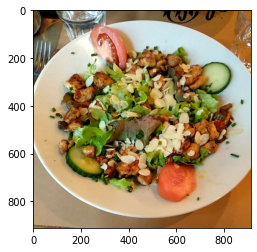

In [219]:
d = test_dict[700]
im = cv2.imread(d["file_name"])[:, :, ::-1]
plt.imshow(im)

almonds
tomato
cucumber
chicken
salad-leaf-salad-green


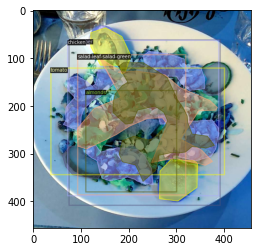

In [224]:
visualizer = Visualizer(im[:,:,::-1], metadata= meta, scale = 0.5)
out = visualizer.draw_dataset_dict(d)
plt.imshow(out.get_image())
metatrain = MetadataCatalog.get("train11")
for i in d["annotations"]:
    lol = np.array(metatrain.thing_classes)
    print(lol[i["category_id"]])


In [225]:
from IPython.display import Image

outputs = predictor(im) 
 # format is documented at https://detectron2.readthedocs.io/tutorials/models.html#model-output-format
v = Visualizer(im[:, :, ::-1], metadata=meta1, scale=0.5 )  # remove the colors of unsegmented pixels. This option is only available for segmentation models
out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
oimg = out.get_image()
Image(oimg)
lol = np.array(meta1.thing_classes)
print(lol[outputs["instances"].to("cpu").pred_classes])
print(np.array(outputs["instances"].to("cpu").scores))

['quinoa' 'mixed-salad-chopped-without-sauce'
 'taboula-c-prepared-with-couscous' 'salad-leaf-salad-green' 'pomegranate'
 'mixed-seeds' 'cucumber' 'avocado' 'cucumber']
[0.0729193  0.07235616 0.06863654 0.06673229 0.06465943 0.06105494
 0.05784236 0.05188642 0.05183563]


In [34]:
outputs["instances"]

Instances(num_instances=0, image_height=426, image_width=426, fields=[pred_boxes: Boxes(tensor([], device='cuda:0', size=(0, 4))), scores: tensor([], device='cuda:0'), pred_classes: tensor([], device='cuda:0', dtype=torch.int64), pred_masks: tensor([], device='cuda:0', size=(0, 426, 426), dtype=torch.bool)])

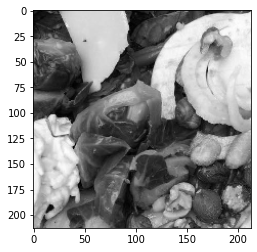

In [27]:
plt.imshow(out)

d = test_dict["images"][0]
im = 